In [1]:
import lightkurve as lk
%matplotlib inline
import starry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import exoplanet as xo

In [2]:
starry.config.lazy = False
starry.config.quiet = True

In [3]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683)

In [4]:
star.map[1] = 0.646 # limb-darkening coefficient
star.map[2] = 0.048

In [5]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
# lc_collection.plot();

In [6]:
search_result.year

array([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011,
       2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013,
       2013, 2013, 2013, 2013])

In [7]:
lc1 = search_result[search_result.year == 2009].download_all()
lc3 = search_result[search_result.year == 2010].download_all()
lc4 = search_result[search_result.year == 2012].download_all()
lc2 = search_result[search_result.year == 2010].download_all() 

In [8]:
lc1 = lc1.stitch()
lc3 = lc3.stitch()
lc4 = lc4.stitch()
lc2 = lc2.stitch()
all_lc = lc_collection.stitch()

In [9]:
lc2.head()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
413.2993275112749,1.0030191e+00,8.4737723e-05,0,-1.525029e-03,551.77573,821.46237,435340,2.7362382e+06,2.2766580e+02,9.8445010e+03,2.6490915e+00,2.7336262e+06,2.3094403e+02,0,———,———,———,———,551.77573,6.7734181e-05,821.46237,2.2456255e-04,-1.3840208e-02,-4.7592893e-02
413.30000861278677,1.0030589e+00,8.4738997e-05,0,-1.525027e-03,551.77539,821.46288,435341,2.7363462e+06,2.2767233e+02,9.8445996e+03,2.6491086e+00,2.7337348e+06,2.3094749e+02,0,———,———,———,———,551.77539,6.7724715e-05,821.46288,2.2455018e-04,-1.3846081e-02,-4.7589939e-02
413.3006897141822,1.0030962e+00,8.4738029e-05,0,-1.525026e-03,551.77472,821.46167,435342,2.7364478e+06,2.2767294e+02,9.8446982e+03,2.6491258e+00,2.7338365e+06,2.3094485e+02,0,———,———,———,———,551.77472,6.7724875e-05,821.46167,2.2443196e-04,-1.3851953e-02,-4.7586981e-02
413.30137091570214,1.0032344e+00,8.4742227e-05,0,-1.525024e-03,551.77466,821.46224,435343,2.7368235e+06,2.2768810e+02,9.8447969e+03,2.6491430e+00,2.7342130e+06,2.3095630e+02,0,———,———,———,———,551.77466,6.7716283e-05,821.46224,2.2442367e-04,-1.3857827e-02,-4.7584023e-02
413.302052017214,1.0029976e+00,8.4732601e-05,10000000000000,-1.525023e-03,551.77503,821.46208,435344,2.7361800e+06,2.2766541e+02,9.8448945e+03,2.6491601e+00,2.7335678e+06,2.3093007e+02,10000000000000,———,———,———,———,551.77503,6.7730653e-05,821.46208,2.2447405e-04,-1.3863700e-02,-4.7581065e-02


In [10]:
lc1['time']

<Time object: scale='tdb' format='bkjd' value=[120.52859841 120.52927953 120.52996076 ... 349.50475254 349.50543371
 349.50611479]>

In [11]:
lc1['time'].format = 'iso'
lc3['time'].format = 'iso'
lc4['time'].format = 'iso'
lc2['time'].format = 'iso'

In [12]:
lc1.tail()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-12-17 00:04:52.929,1.0030860e+00,8.7367946e-05,0,-3.595564e-04,552.16784,816.86224,341675,2.8875612e+06,2.4201497e+02,6.5285693e+03,2.7677212e+00,2.9114090e+06,2.5358130e+02,0,———,———,———,———,552.16784,7.5604752e-05,816.86224,2.2205619e-04,1.4176921e-03,2.6190327e-02
2009-12-17 00:05:51.774,1.0031037e+00,8.7396955e-05,0,-3.595806e-04,552.16810,816.86110,341676,2.8875545e+06,2.4201660e+02,6.5289941e+03,2.7677925e+00,2.9114608e+06,2.5366548e+02,0,———,———,———,———,552.16810,7.5573349e-05,816.86110,2.2211265e-04,1.4145803e-03,2.6193406e-02
2009-12-17 00:06:50.619,1.0027026e+00,8.7411841e-05,0,-3.596049e-04,552.16918,816.86196,341677,2.8863402e+06,2.4196829e+02,6.5294180e+03,2.7678638e+00,2.9102965e+06,2.5370869e+02,0,———,———,———,———,552.16918,7.5603872e-05,816.86196,2.2207269e-04,1.4114685e-03,2.6196485e-02
2009-12-17 00:07:49.473,1.0031241e+00,8.7460110e-05,0,-3.596292e-04,552.16934,816.86214,341678,2.8874898e+06,2.4201254e+02,6.5298423e+03,2.7679350e+00,2.9115200e+06,2.5384880e+02,0,———,———,———,———,552.16934,7.5579759e-05,816.86214,2.2210415e-04,1.4083562e-03,2.6199566e-02
2009-12-17 00:08:48.318,1.0031514e+00,8.7496548e-05,0,-3.596535e-04,552.16892,816.86241,341679,2.8875022e+06,2.4201241e+02,6.5302671e+03,2.7680063e+00,2.9115990e+06,2.5395454e+02,0,———,———,———,———,552.16892,7.5575284e-05,816.86241,2.2209880e-04,1.4052445e-03,2.6202645e-02


In [12]:
lc1['time'].value[-1].split('-')[2].split(' ')[0]

'17'

In [13]:
lc1['time'].value[-1].split('-')[1]

'12'

In [14]:
mask3 = [i.split('-')[1]=='04' and i.split('-')[2].split(' ')[0]=='18' for i in lc3['time'].value]
mask1 = [i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='02' for i in lc1['time'].value]
mask2 = [i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='31' for i in lc1['time'].value]
mask4 = [i.split('-')[1]=='01' and i.split('-')[2].split(' ')[0]=='08' for i in lc4['time'].value]

In [15]:
lc2 = lc1[mask2]
lc1 = lc1[mask1]
lc3 = lc3[mask3]
lc4 = lc4[mask4]

In [16]:
lc1['time'].format = 'bkjd'
lc2['time'].format = 'bkjd'
lc3['time'].format = 'bkjd'
lc4['time'].format = 'bkjd'

In [17]:
lc1['time']

<Time object: scale='tdb' format='bkjd' value=[334.50024832 334.5009294  334.50161047 ... 335.49804959 335.49873077
 335.49941184]>

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

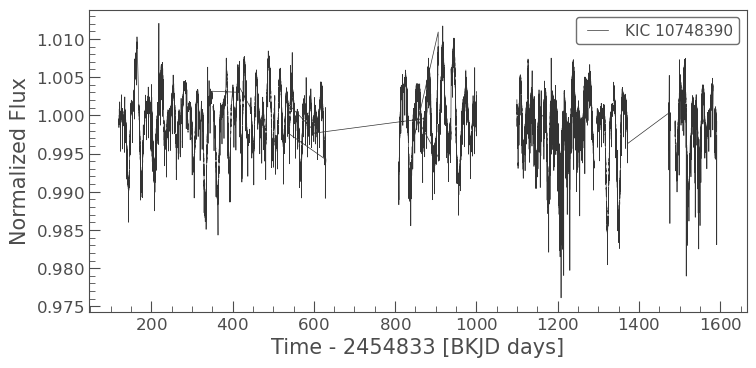

In [20]:
all_lc.plot()

In [100]:
period = np.linspace(2, 20, 10000)
bls = all_lc.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power*1.5
print(period)

[ 2.          2.00180018  2.00360036 ... 19.99639964 19.99819982
 20.        ]


In [102]:
planet_period

<Quantity 4.88748875 d>

In [111]:
planet_t0

<Time object: scale='tdb' format='bkjd' value=124.85859840558085>

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

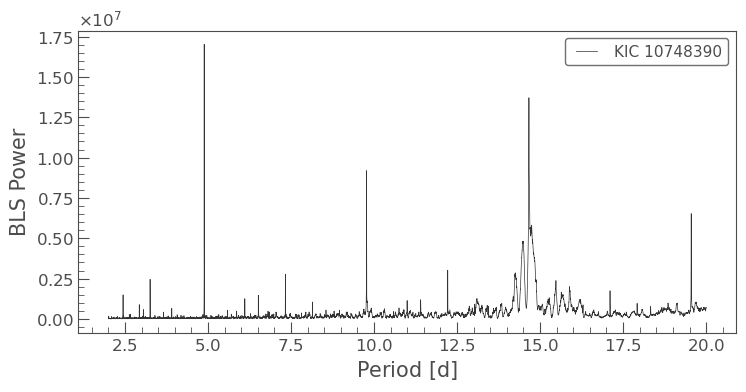

In [101]:
bls.plot()

In [44]:
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))

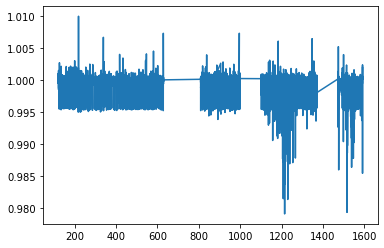

In [45]:
plt.plot(all_lc.time.value, all_lc.flatten(mask=tranmask).flux)

In [112]:
starry.config.lazy = True
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    # offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)
    # log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)
    u1 = pm.Uniform("u1", lower=0.638,upper=0.7)
    u2 = pm.Uniform("u2", lower=0.033,upper=0.064) 
    rp = pm.Uniform("rp", lower=0.03232321,upper=0.04632)
    # mass_p = pm.Uniform("mp", lower=7.0000e-5,upper=7.5e-5) 
    # The log period; also tracking the period itself
    # logP = pm.Normal("logP", mu=np.log(np.random.uniform(1, 10)), sd=0.1)
    # period = pm.Deterministic("period", pm.math.exp(logP))
    period = pm.Uniform("porb", lower=4,upper=5, testval=4.888)
    t0 = pm.Uniform("t0", lower=124,upper=125, testval=124.85) 

    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0
    )
    A.map[1] = u1
    A.map[2] = u2

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, obl=0.0, amp=0),
        m=7.0257708e-5,  # mass in solar masses
        r=rp,   # radius in solar radii
        inc=88.99, # orbital inclination
        porb=period,  # orbital period in days
        prot=1,
        w=-162.149,  # Argument of periastron (little omega)
        ecc=0.265,  # eccentricity
        Omega=106, 
        t0=t0, # 
    )
    #b.map[1, 0] = 0.5
    # b.theta0 = 180.0 + offset

    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(all_lc.time.value))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    pm.Normal("obs", flux_model, sd=all_lc.flatten(mask=tranmask).flux_err, observed=np.array(all_lc.flatten(mask=tranmask).flux))

In [122]:
pmx.eval_in_model(flux_model, model=model)

array([1., 1., 1., ..., 1., 1., 1.])

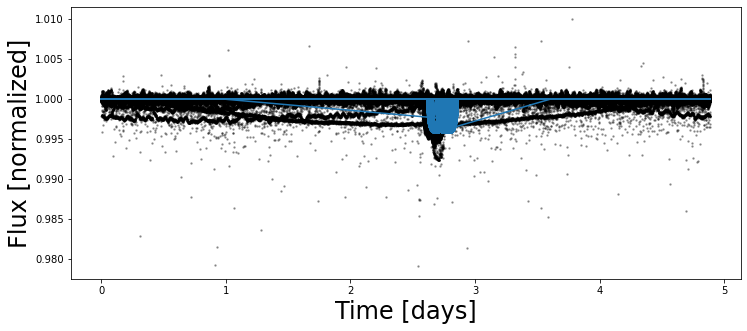

In [123]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value%np.float64(planet_period), all_lc.flatten(mask=tranmask).flux.value, "k.", alpha=0.3, ms=3)
plt.plot(all_lc.time.value%np.float64(planet_period), pmx.eval_in_model(flux_model, model=model))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [124]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x190248490>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x190248490>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, porb, rp, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -34147456.54217569 -> 4783634.863279567


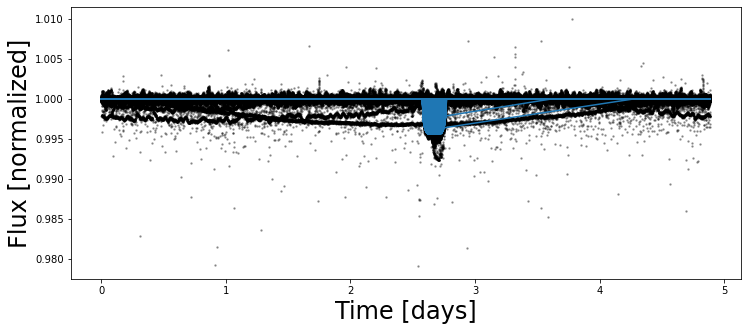

In [126]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value%np.float64(planet_period), all_lc.flatten(mask=tranmask).flux.value, "k.", alpha=0.3, ms=3)
plt.plot(all_lc.time.value%np.float64(planet_period), map_soln['flux_model'])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [127]:
map_soln['porb']

array(4.88780245)

In [128]:
map_soln['t0']

array(124.81315096)

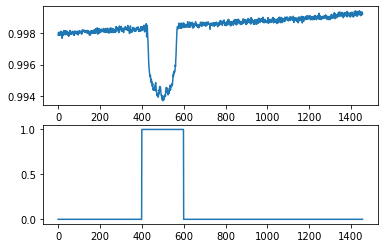

In [80]:
mask = np.zeros(len(lc3.flux), dtype=bool)
mask[400:600] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc3.flux)
ax[1].plot(mask)

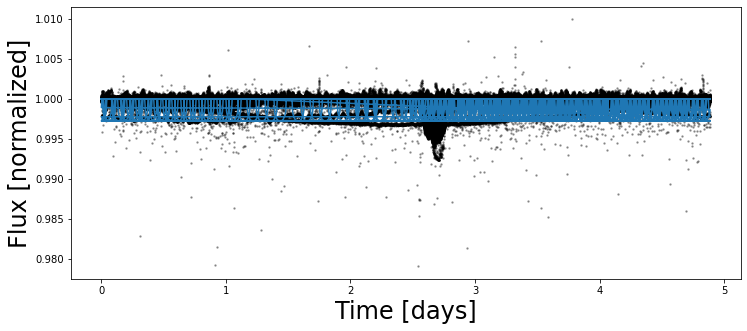

In [110]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value%np.float64(planet_period), all_lc.flatten(mask=tranmask).flux.value, "k.", alpha=0.3, ms=3)
plt.plot(all_lc.time.value%np.float64(planet_period), map_soln["flux_model"])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [129]:
starry.config.lazy = False
starry.config.quiet = True

In [25]:
pg4 = lc4.to_periodogram(minimum_period = 4.08,
                      maximum_period = 5,
                      oversample_factor=100)
pg3 = lc3.to_periodogram(minimum_period = 4.2,
                      maximum_period = 5,
                      oversample_factor=100)
pg1 = lc1.to_periodogram(minimum_period = 4.2,
                      maximum_period = 5,
                      oversample_factor=100)

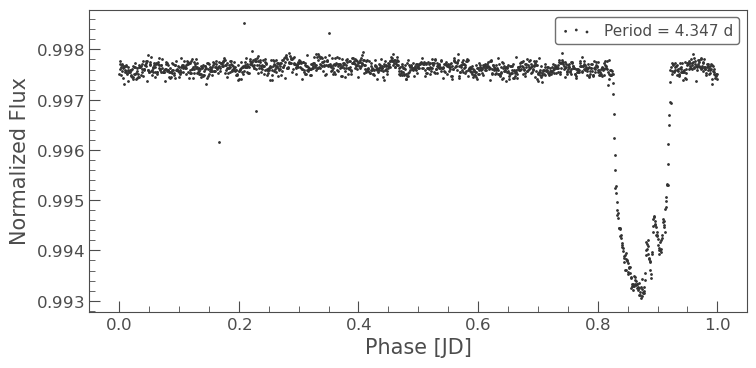

In [27]:
period4 = pg4.period_at_max_power
period3 = pg3.period_at_max_power
period1 = pg1.period_at_max_power
lc4.fold(period4).scatter(label=rf'Period = {period1.value:.3f} d');

In [130]:
planet4 = starry.kepler.Secondary(
    starry.Map(udeg=2),  # the surface map
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=map_soln['porb'],  # orbital period in days
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=map_soln['t0'],  # time of transit in days
)

planet3 = starry.kepler.Secondary(
    starry.Map(udeg=2),  # the surface map
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=map_soln['porb'],  # orbital period in days
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=map_soln['t0'],  # time of transit in days
)

planet1 = starry.kepler.Secondary(
    starry.Map(udeg=2),  # the surface map
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=map_soln['porb'],  # orbital period in days
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=map_soln['t0'],  # time of transit in days
)

In [38]:
period = np.linspace(4.8, 5, 10000)
# Create a BLSPeriodogram
bls4 = lc4.to_periodogram(method='bls', period=period, frequency_factor=500);
bls3 = lc3.to_periodogram(method='bls', period=period, frequency_factor=500);
bls1 = lc1.to_periodogram(method='bls', period=period, frequency_factor=500);

In [39]:
bls3.period_at_max_power

<Quantity 4.8 d>

In [131]:
system4 = starry.System(star, planet4)
time4 = lc4.normalize().fold(period=map_soln['porb'], epoch_time=map_soln['t0'])['time'].value

system3 = starry.System(star, planet3)
time3 = lc3.flatten(mask=mask).fold(period=map_soln['porb'], epoch_time=map_soln['t0'])['time'].value

system1 = starry.System(star, planet1)
time1 = lc1.normalize().fold(period=map_soln['porb'], epoch_time=map_soln['t0'])['time'].value

In [41]:
time4

array([-0.875     , -0.87431882, -0.87363774, ...,  0.12280908,
        0.12349025,  0.12417133])

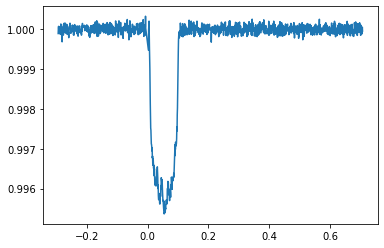

In [77]:
mask = np.zeros(len(lc3.flux), dtype=bool)
mask[400:600] = 1
# ax = lc3.flatten(mask=mask).fold(period=map_soln['porb']).scatter()
plt.plot(time3, lc3.flatten(mask=mask).fold(period=map_soln['porb']).flux)

In [132]:
flux_star4, flux_planet4 = system4.flux(time4, total=False)
flux_star3, flux_planet3 = system3.flux(time3, total=False)
flux_star1, flux_planet1 = system1.flux(time1, total=False)

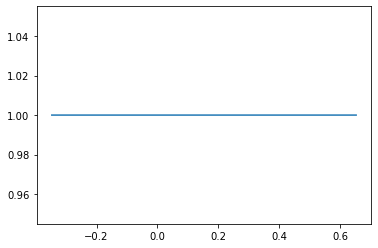

In [134]:
#plt.plot(time3, lc3.flatten(mask=mask).fold(period=map_soln['porb']).flux)
plt.plot(time3, flux_star3)

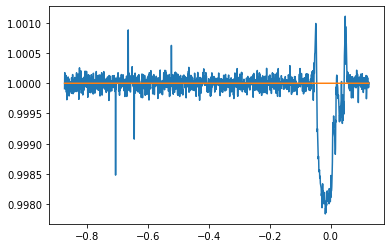

In [135]:
plt.plot(time4, lc4.flatten().fold(period=map_soln['porb']).flux)
plt.plot(time4, flux_star4)

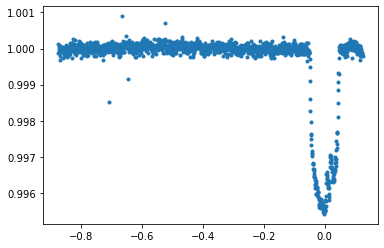

In [43]:
plt.plot(time4,
    lc4.normalize().fold(period=period4)['flux'],'.')

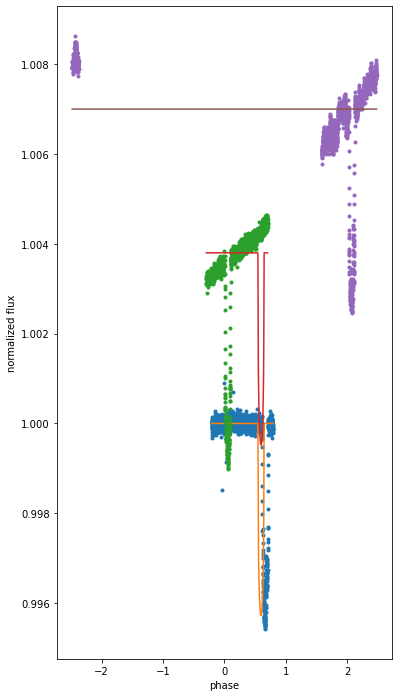

In [68]:
flux_star4, flux_planet4 = system4.flux(time4, total=False)
flux_star3, flux_planet3 = system3.flux(time3, total=False)
flux_star1, flux_planet1 = system1.flux(time1, total=False)

fig = plt.subplots(figsize=(6, 12), sharex=True)

# lc4.normalize().fold(period=period4, epoch_time=bls4.transit_time_at_max_power).scatter()
plt.plot(time4,(lc4.normalize().fold(period=map_soln['porb'], epoch_time=map_soln['t0']).flux),'.')
plt.plot(time4, flux_star4)

# (lc3.normalize().fold(period=period3, epoch_time=bls3.transit_time_at_max_power)+0.004).scatter()
plt.plot(time3,(lc3.normalize().fold(period=map_soln['porb'], epoch_time=map_soln['t0']).flux+0.0038),'.')
plt.plot(time3, flux_star3+0.0038)

# (lc1.normalize().fold(period=period1, epoch_time=bls1.transit_time_at_max_power)+0.008).scatter()
plt.plot(time1,(lc1.normalize().fold(period=map_soln['porb'], epoch_time=map_soln['t0']).flux+0.007),'.')
plt.plot(time1, flux_star1+0.007)

# plt.xlim(-0.1,0.1)
plt.xlabel("phase")
plt.ylabel("normalized flux");
plt.show()